In [1]:
import pandas as pd
import numpy as np
import pycountry
from scipy.optimize import least_squares
import random
import statsmodels
from scipy.optimize import minimize
from scipy.optimize import fsolve
from pandas.core import datetools
import statsmodels.api as sm
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from collections import defaultdict
from math import pi, e
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import scipy 

/home/sara/myenv/lib64/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  if __name__ == '__main__':


In [2]:
resident_foreigners_norm = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/resident_foreigners_norm.csv")

province_capitals = ['Ancona', "Valle d'Aosta / Vallée d'Aoste", "L'Aquila", 'Bari', 'Bologna', 'Cagliari', 'Campobasso', 'Catanzaro', 'Firenze', 'Genova', 'Milano', 'Napoli', 'Palermo', 'Perugia', 'Potenza', 'Roma', 'Torino', 'Trento', 'Trieste', 'Venezia']
# Untill 2011 - in 2011 change
#years = list(range(2004, 2018))

In [3]:
resident_foreigners_norm.head()

,Province,Country,Year,Gender,Value
0,Biella,AND,2005,male,1
1,Biella,AND,2005,female,0
2,Novara,AND,2005,male,0
3,Novara,AND,2005,female,2
4,Alessandria,AND,2017,male,0


In [4]:
regions = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/regioni.csv")
regions_info = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/region_info.csv")

prov_info = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/prov_cap_info.csv")

mezzogiorno = {'Abruzzo': 1, 'Lazio': 0, 'Umbria': 0, 'Provincia Autonoma Trento': 0, 
               'Friuli-Venezia Giulia': 0, 'Molise': 1, 'Calabria': 1, 
               "Valle d'Aosta / Vallée d'Aoste": 0, 'Lombardia': 0, 'Liguria': 0, 
               'Emilia-Romagna': 0, 'Sicilia': 1, 
               'Provincia Autonoma Bolzano / Bozen': 0, 'Puglia': 1, 'Campania': 1, 
               'Piemonte': 0, 'Toscana': 0, 'Sardegna': 1, 'Marche': 0, 
               'Basilicata': 1, 'Veneto': 0}

In [5]:
x_df = pd.DataFrame()
x_df = prov_info[["Prov Capitals", "Area", "Dens"]].copy()
# Logarithmic transformation
x_df["Area"] = np.log(x_df["Area"])
x_df["Dens"] = np.log(x_df["Dens"])
x_df["Mezzogiorno"] = [mezzogiorno[regions[regions["Provincia"] == i]["Regione"].values[0]] for i in x_df["Prov Capitals"].values]

In [6]:
x_df.head()

,Prov Capitals,Area,Dens,Mezzogiorno
0,Ancona,7.582341,5.488938,0
1,Valle d'Aosta / Vallée d'Aoste,8.089759,3.663562,0
2,L'Aquila,8.526658,4.094345,1
3,Bari,8.259168,5.786897,1
4,Bologna,8.216715,5.609472,0


In [7]:
# Get the foreigners stock value
def n_it(data_, i, t):
    return(data_[(data_["Province"] == i) & (data_["Year"] == t)]["Value"].values[0])

In [8]:
def count(data_):
    count_obj = defaultdict(lambda: 0)
    for i in data_:
        count_obj[i] += 1
    return(count_obj)

In [9]:
# Do not consider provinces with missing values (0 immigrants) for more than two years (>= 3) (My Assumption!)
def not_including(data_, times, territories):
    temp_not_in = list()
    for i in territories:
        for t in times:
            try:
                temp = data_[(data_["Province"] == i) & (data_["Year"] == t)]["Value"].values[0]
            except IndexError:
                temp_not_in.append(i)
    not_in_count = count(temp_not_in)
    not_in = [k for k, v in not_in_count.items() if v >= 3]
    return(not_in)

In [10]:
data = resident_foreigners_norm.copy()
data = data.groupby(["Province", "Country", "Year"], as_index=False).sum()

In [14]:
data.head()

,Province,Country,Year,Value
0,Agrigento,AFG,2008,2
1,Agrigento,AFG,2009,12
2,Agrigento,AFG,2010,51
3,Agrigento,AFG,2011,35
4,Agrigento,AFG,2012,21


In [15]:
def simple_regression_model(data_all, country, times, territories = None):
    if not territories:
        territories = list(set(data_all["Province"]))
        
    #territories = list(set(data_all["Province"]))

    data_all = data_all[data_all["Year"].isin(times)]
    missing_territories = not_including(data_all, times, territories)
    territories = [i for i in territories if i not in missing_territories]
    data_all = data_all[data_all["Province"].isin(territories)]

    # Also the stock in the refered province is needed in the optimization 
    data_ = data_all[data_all["Country"] == pycountry.countries.get(name=country).alpha_3]
    del data_["Country"]
    
    x = []
    y = []

    for i in territories:
        for t in times[1:]:
            #y.append(np.log(n_it(data_, i, t)/n_it(data_, I, t)))
            x.append(np.log(n_it(data_, i, t-1)))
            y.append(np.log(n_it(data_, i, t)))

    X = np.matrix([[1 for i in x], x]).T
    Y = np.array(y)
    
    b = np.dot(np.dot(np.dot(X.T, X)**(-1), X.T), Y)
    
    return(b.item(0, 1), b.item(0, 0))

In [16]:
def R2_simple_regression_model(res_, data_all, country, times, territories = None):
    if not territories:
        territories = list(set(data_all["Province"]))
        
    #territories = list(set(data_all["Province"]))

    data_all = data_all[data_all["Year"].isin(times)]
    missing_territories = not_including(data_all, times, territories)
    territories = [i for i in territories if i not in missing_territories]
    data_all = data_all[data_all["Province"].isin(territories)]

    # Also the stock in the refered province is needed in the optimization 
    data_ = data_all[data_all["Country"] == pycountry.countries.get(name=country).alpha_3]
    del data_["Country"]
    
    Y_hat = []
    Y = []
    for i in territories:
        for t in times[1:]:
            Y.append(n_it(data_, i, t))
            Y_hat.append(e**(res_[0]*np.log(n_it(data_, i, t-1)) + res_[1]))

            
    # I has to be included in the prediction and in the prediction and in the R2 computation
    Y_mean = np.mean(Y)
    R2 = 1 - sum(np.subtract(Y, Y_hat)**2) / sum((Y - Y_mean)**2)
    #print(R2)
    MSE = sum(np.subtract(Y, Y_hat)**2)/len(Y)
    
    print("The R2 score is: %f" %R2)
    print("The MSE score is: %f" %MSE)

    print("The Pearson's correlation coefficient is: %f, with p-value %f" %(scipy.stats.pearsonr(Y, Y_hat)[0], scipy.stats.pearsonr(Y, Y_hat)[1]))
    print("The Spearman's correlation coefficient is: %f, with p-value %f" %(scipy.stats.spearmanr(Y, Y_hat)[0], scipy.stats.spearmanr(Y, Y_hat)[1]))
    print("The Kendall's correlation coefficient is: %f, with p-value %f" %(scipy.stats.kendalltau(Y, Y_hat)[0], scipy.stats.kendalltau(Y, Y_hat)[1]))

This would be the result for a model like:
    $$ln(n_{i,t}) = \beta_0ln(n_{i,t-1}) + \beta_1 + \epsilon$$

In [17]:
interest_countries = ["Morocco", "Tunisia", "Peru", "China", "Philippines", "Albania", 
                      "Romania"]

In [19]:
for c in interest_countries:
    temp = simple_regression_model(data, c, list(range(2005, 2016)), province_capitals)
    print("------------------------", c,"------------------------")
    print("Beta0 parameter: %f" %temp[0])
    print("Beta1 parameter: %f" %temp[1])
    R2_simple_regression_model(temp, data, c, list(range(2005, 2016)), province_capitals)

------------------------ Morocco ------------------------
Beta0 parameter: 0.986108
Beta1 parameter: 0.160597
The R2 score is: 0.986286
The MSE score is: 581107.885274
The Pearson's correlation coefficient is: 0.993157, with p-value 0.000000
The Spearman's correlation coefficient is: 0.995121, with p-value 0.000000
The Kendall's correlation coefficient is: 0.950744, with p-value 0.000000
------------------------ Tunisia ------------------------
Beta0 parameter: 0.977467
Beta1 parameter: 0.173795
The R2 score is: 0.971234
The MSE score is: 44168.932342
The Pearson's correlation coefficient is: 0.985596, with p-value 0.000000
The Spearman's correlation coefficient is: 0.992148, with p-value 0.000000
The Kendall's correlation coefficient is: 0.934620, with p-value 0.000000
------------------------ Peru ------------------------
Beta0 parameter: 0.998109
Beta1 parameter: 0.074323
The R2 score is: 0.995607
The MSE score is: 203545.814519
The Pearson's correlation coefficient is: 0.997807, wi

In [20]:
def real_vs_prediction2(res_, data_, country, time, territories = None):
    
    if not territories:
        territories = list(set(data_all["Province"]))
        
    data_ = data_[data_["Country"] == pycountry.countries.get(name=country).alpha_3]
    del data_["Country"]
    
    prediction = defaultdict(list)
    real = defaultdict(list)

    
    for i in territories:
        for t in time[1:]:
            real[t].append(n_it(data_, i, t))
            prediction[t].append(e**(res_[0]*np.log(n_it(data_, i, t-1)) + res_[1]))

    sns.set_style("whitegrid")
    sns.set_context({"figure.figsize": (10, 8)})

    for k, v in real.items():
        legend = []
        sns.pointplot(y = v, x = territories, label= "Real")
        legend.append(mlines.Line2D([], [], markersize=15, label="Real"))
        sns.pointplot(y = prediction[k], x = territories, label= "Prediction", color = "red")
        legend.append(mlines.Line2D([], [], color="red", markersize=15, label="Prediction"))

        plt.xticks(rotation=90)
        sns.despine(left=True)
        plt.xlabel("Province Capitals", fontsize=12)
        plt.ylabel("Abs Population", fontsize=12)
        plt.legend(handles = legend, prop={'size':14}, loc='upper right', bbox_to_anchor=(1.25, 1.), ncol=1)
        plt.title("%s prediction - %d" %(country, k), fontsize = 16)
        plt.show()

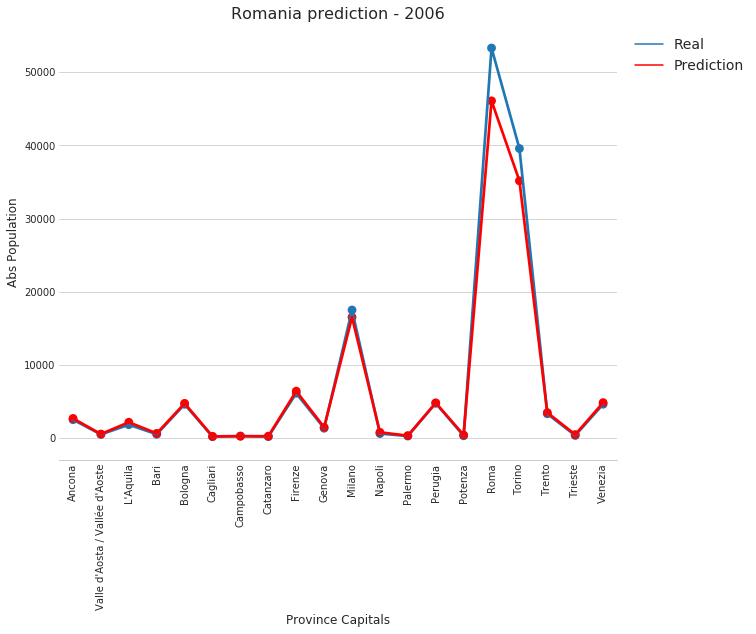

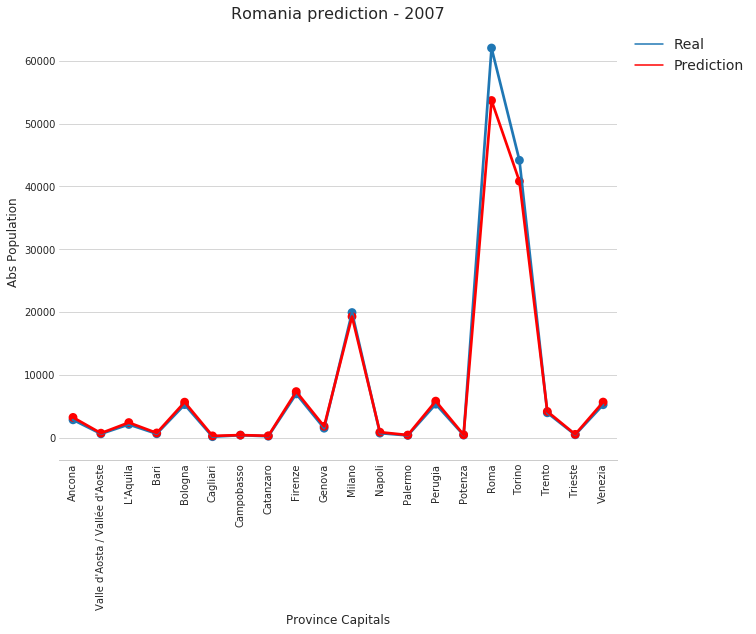

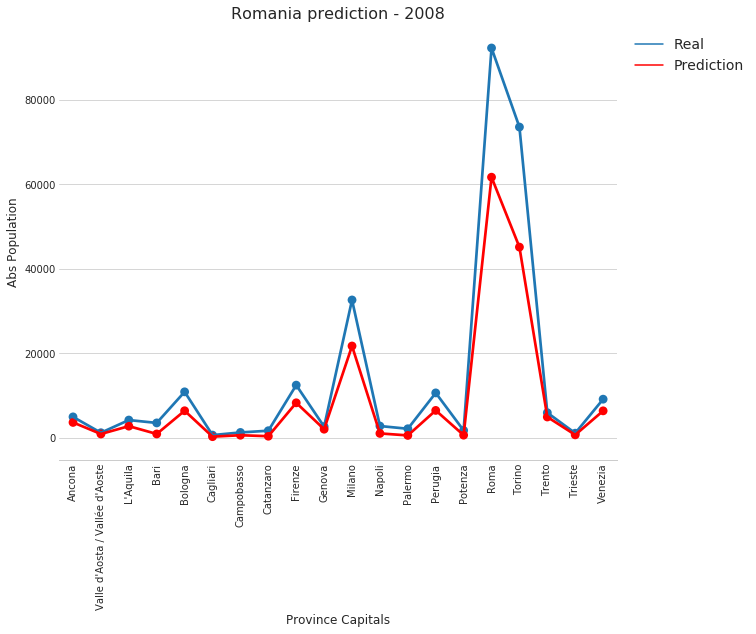

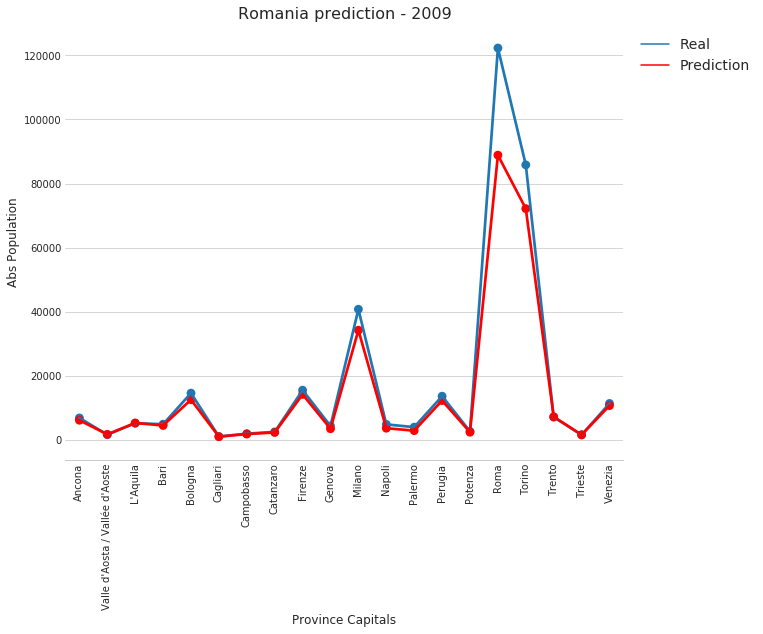

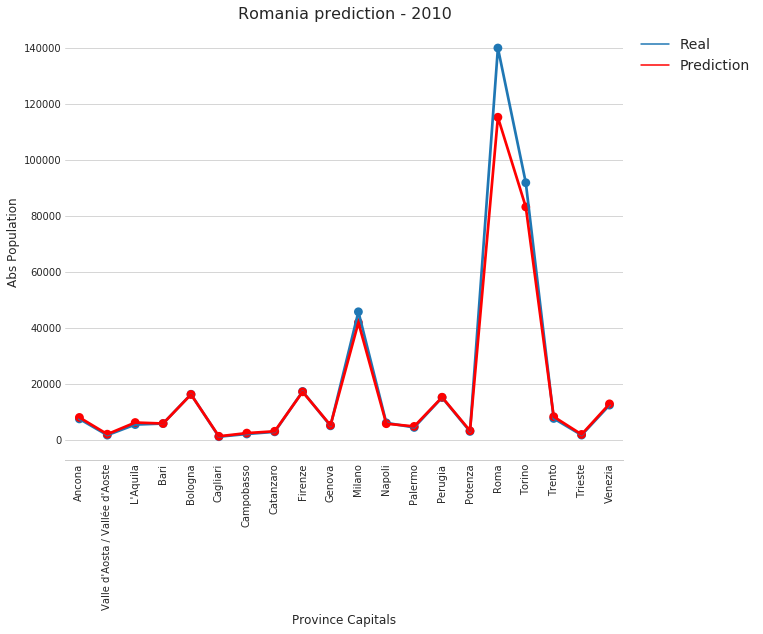

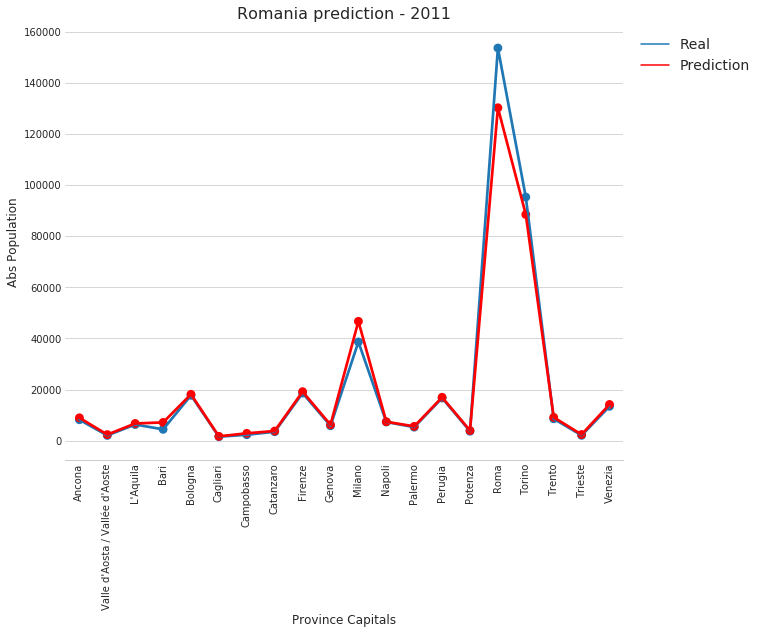

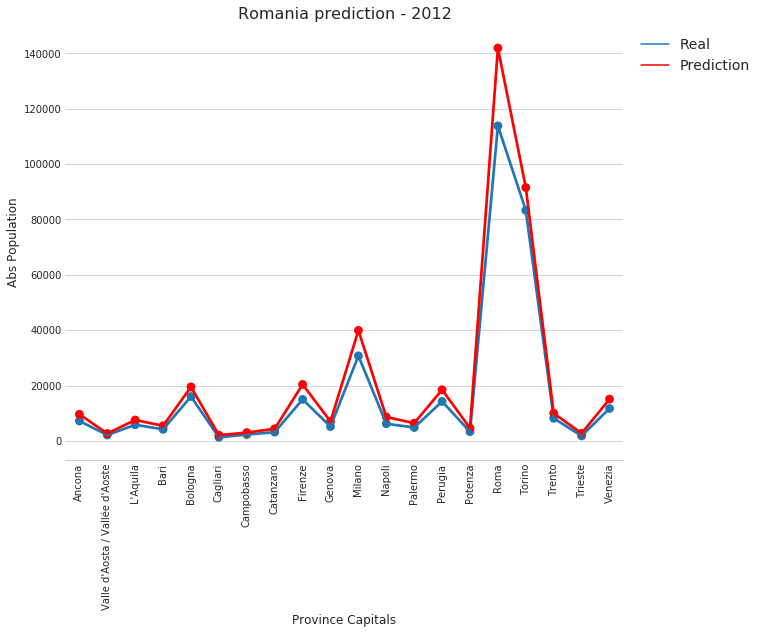

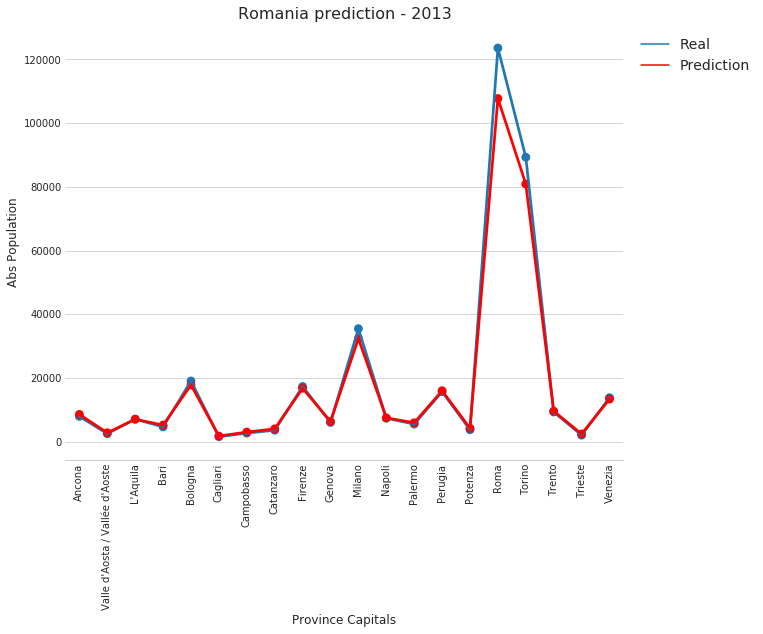

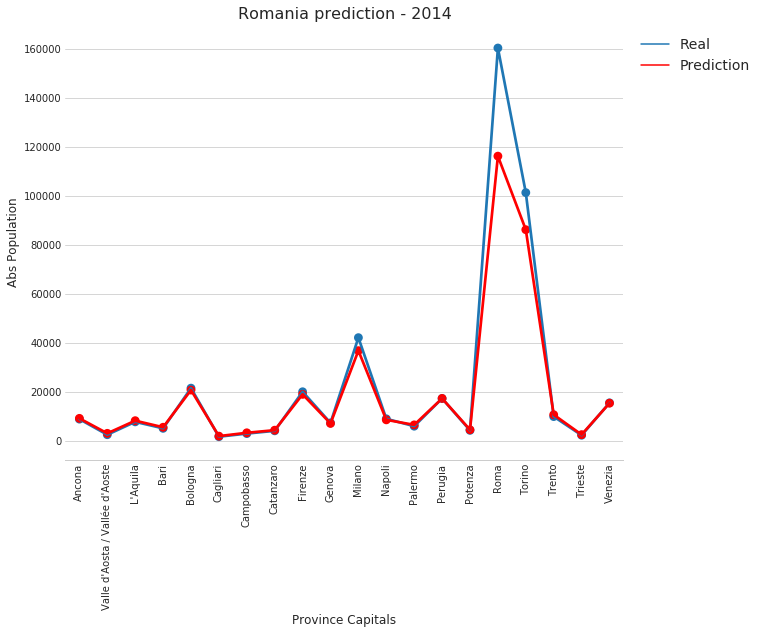

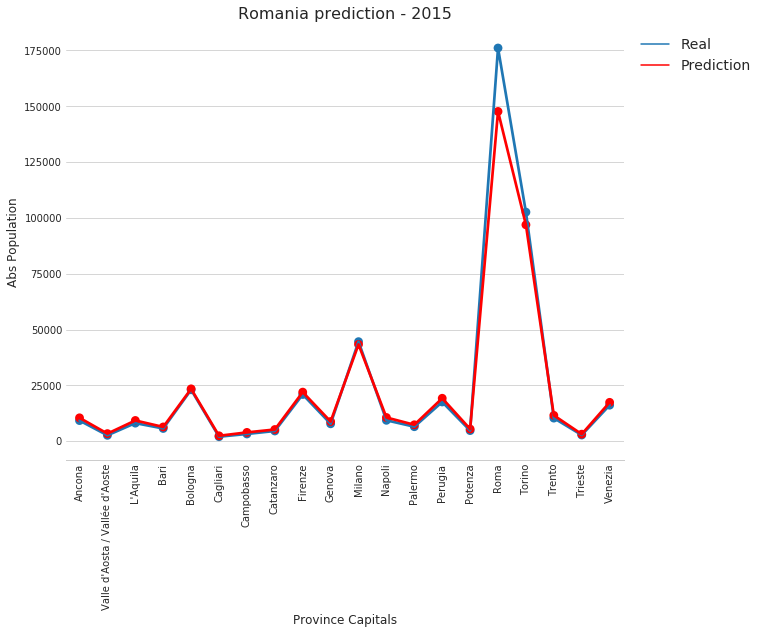

In [24]:
real_vs_prediction2([0.918779, 0.890998], data, "Romania", list(range(2005, 2016)), province_capitals)

In [23]:
real_vs_prediction2(res_chi, data, "China", list(range(2005, 2016)), province_capitals)

NameError: name 'res_chi' is not defined